In [3]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import yfinance as yf
import pandas_datareader as pdr
from datetime import datetime


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


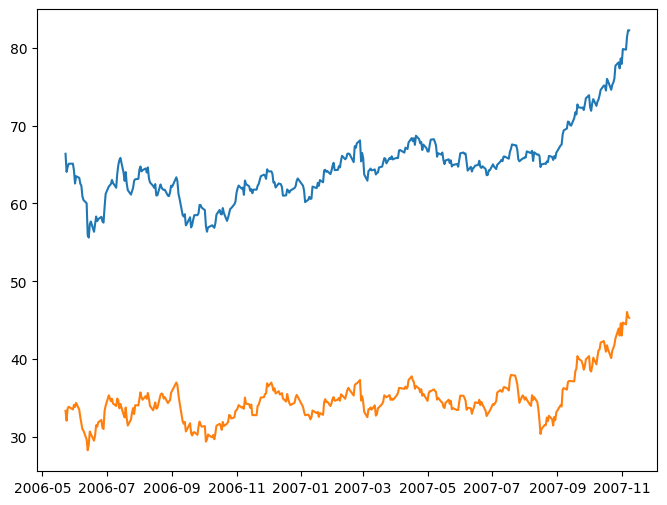

In [4]:
df1 = yf.download('GLD' , datetime(2006,5, 23), datetime(2007, 11, 9))['Adj Close']
df2 = yf.download('GDX', datetime(2006,5, 23), datetime(2007, 11, 9))['Adj Close']
df = pd.merge(df1, df2, on='Date', suffixes=('_GLD', '_GDX'))

train = np.arange(0, 252)
test = np.arange(train.shape[0], df.shape[0])

plt.rcParams['figure.figsize'] = 8, 6
plt.plot(df)


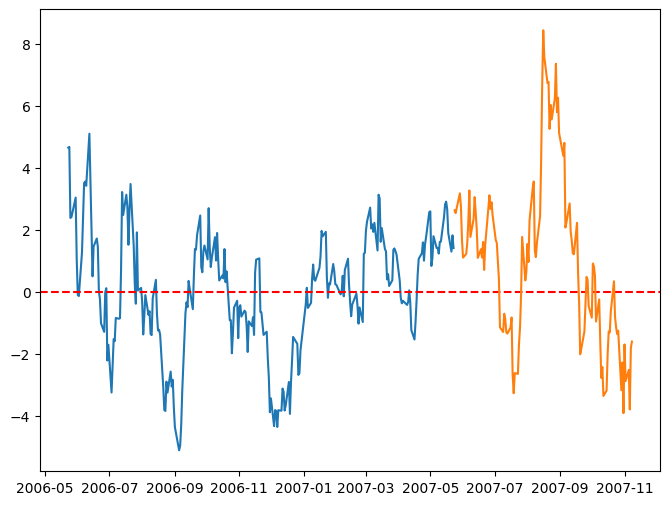

In [5]:
model = sm.OLS(df.loc[:, 'Adj Close_GLD'].iloc[train], df.loc[:, 'Adj Close_GDX'].iloc[train])
result = model.fit()
b = result.params[0]

spread = df.loc[:,'Adj Close_GLD'] - b * df.loc[:,'Adj Close_GDX']
plt.plot(spread.iloc[train])
plt.axhline(0, linestyle='--', color='r')
plt.plot(spread.iloc[test])


In [6]:
from statsmodels.tsa.stattools import adfuller
adfuller(spread)

(-4.02399450909299,
 0.0012899513325677434,
 0,
 369,
 {'1%': -3.448196541708585,
  '5%': -2.869404683789669,
  '10%': -2.5709597356805545},
 891.7431109327065)

In [7]:
from statsmodels.tsa.stattools import coint
if coint(df1,df2)[1] < 0.05:
    print ('pvalue is: ', coint(df1,df2)[1],  'the series are cointegrated')
else:
    print ('pvalue is: ', coint(df1,df2)[1],  'the series are not cointegrated')


pvalue is:  0.03394158491899178 the series are cointegrated


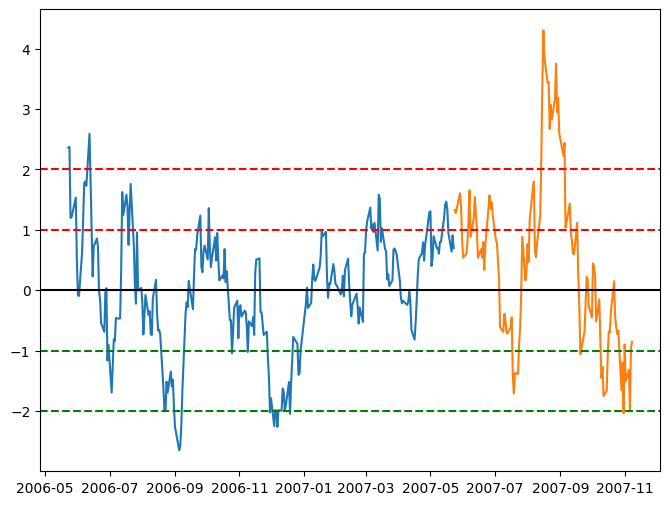

In [20]:
spreadMean = np.mean(spread.iloc[train])
spreadStd = np.std(spread.iloc[train])
df['zscore'] = (spread - spreadMean) / spreadStd
df['position_GLD_long'] = 0
df['position_GDX_long'] = 0
df['position_GDX_short'] = 0
df['position_GLD_short'] = 0

#short spread
df.loc[df.zscore >=2, ('position_GLD_short', 'position_GDX_short' ) ] = [-1 , 1]

#buy spread
df.loc[df.zscore <=-2, ('position_GLD_long', 'position_GDX_long' ) ] = [1 , -1]

#exit short spread
df.loc[df.zscore <=1, ('position_GLD_short', 'position_GDX_short' ) ] = 0

#exit long spread
df.loc[df.zscore >=-1, ('position_GLD_long', 'position_GDX_long' ) ] = 0
df.fillna(method='ffill', inplace=True)

plt.plot(df['zscore'][train])
plt.plot(df['zscore'][test])
plt.axhline(0, color='black')
plt.axhline(2, color='r', linestyle='--') #95.5% , z = 2
plt.axhline(1, color='r', linestyle='--') #68%, z = 1
plt.axhline(-1, color='g', linestyle='--')
plt.axhline(-2, color='g', linestyle='--')

position_long = df.loc[:, ('position_GLD_long', 'position_GDX_long')]
position_short = df.loc[:, ('position_GLD_short', 'position_GDX_short')]

position = np.array(position_long) + np.array(position_short)
position=pd.DataFrame(position)



In [9]:
dailyret = df.loc[:, ( 'Adj Close_GLD', 'Adj Close_GDX')].pct_change()

pnl=(np.array(position.shift())*np.array(dailyret)).sum(axis=1)


In [10]:
sharpetrain = np.sqrt(624) * np.mean(pnl[train[1:]]) / np.std(pnl[train[1:]])
sharpetrain

3.338332807955125

In [11]:
sharpetest = np.sqrt(624) * np.mean(pnl[test]) / np.std(pnl[test])
sharpetest

1.6950538501616577

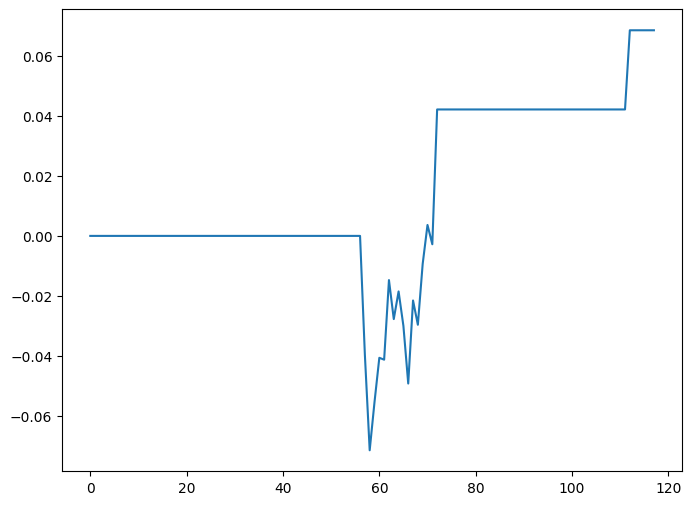

In [12]:
plt.plot(np.cumsum(pnl[test]))


In [15]:
class MyKalmanFilter:
    
    def __init__(self, delta=1e-4, R=1e-3):
        # measurement noise variance
        self.R = R

        # co-variance of process noise(2 dimensions)
        self.Q = delta / (1-delta) * np.eye(2)

        # state (slope, intercept) will be (2 x n), we will initialize with just one column at first
        self.x = np.zeros((2, 1))     

        # state covariance
        self.P = np.zeros((2,2))     

    def step_forward(self, y1, y2):
        # Before entering the equations, let's define H as (1, 2) matrix
        H = np.array([y2, 1])[None]
        # and define z
        z = y1

        ## TIME UPDATE ##
        # first thing is to predict new state as the previous one (2x1)
        x_hat = self.x[:, -1][..., None]

        # then, the uncertainty or covariance prediction 
        P_hat = self.P + self.Q

        ## MEASUREMENT UPDATE ##
        # calc the Kalman gain
        K = P_hat.dot(H.T)/(H.dot(P_hat.dot(H.T))+self.R)

        # state update part 1 (measurement estimation)
        z_hat = H.dot(x_hat)
        # state update part 2
        x = x_hat + K.dot(z-z_hat)

        # uncertainty update
        self.P = (np.eye(2)-K.dot(H)).dot(P_hat)

        # append the new state to the vector
        self.x = np.concatenate([self.x, x], axis=1)

        return x, self.P, K, z_hat



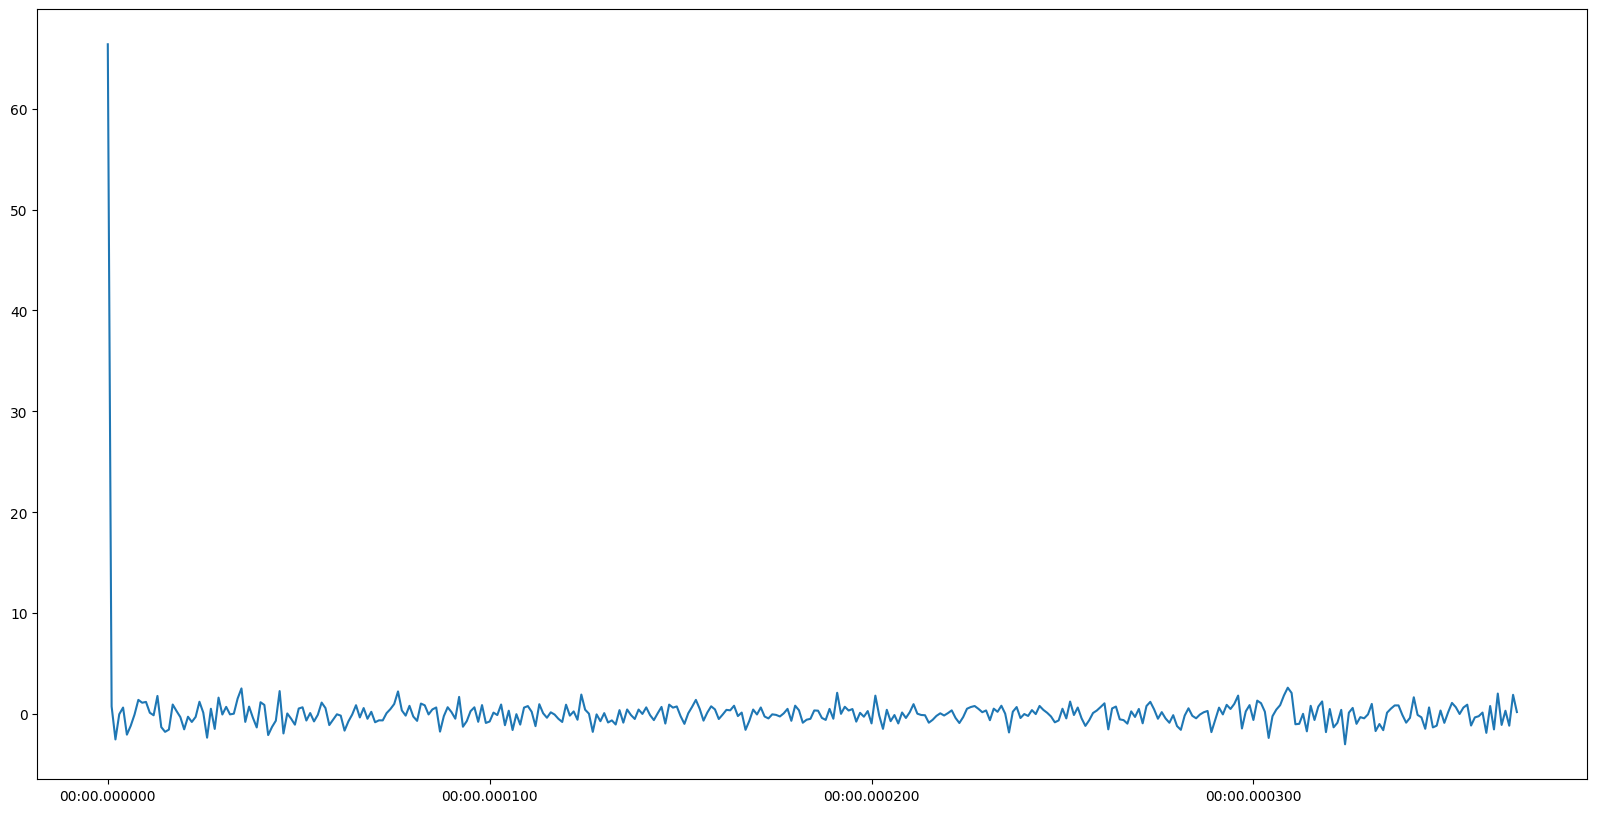

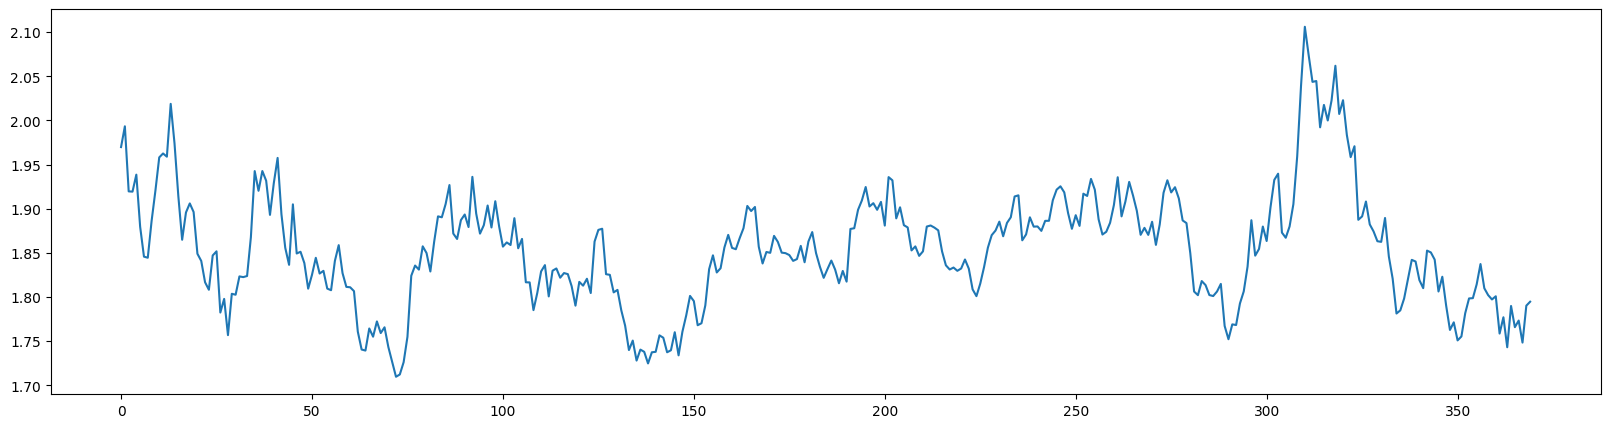

In [16]:
mkf = MyKalmanFilter(delta=1e-4, R=1e-3)
series = df.loc[:, ('Adj Close_GLD', 'Adj Close_GDX')]
result = []

for idx, row in df.iterrows():
    x, P, K, z_hat = mkf.step_forward(row['Adj Close_GLD'], row['Adj Close_GDX'])
    result.append(row['Adj Close_GLD'] - z_hat.squeeze())

result_df = pd.DataFrame(result, columns=['Combined_Portfolio'])
series = pd.concat([series, result_df], axis=1)

# Plot the combined portfolio
plt.figure(figsize=(20, 10))
plt.plot(series['Combined_Portfolio'][10:])

# Plot the hedge ratio over time
plt.figure(figsize=(20, 5))
plt.plot(mkf.x[0, 1:])